In [13]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py
#%matplotlib widget, remove below if used
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [14]:
def prepare_profile_data(files,spin_data_structure="New"):
    # spin data structure changed to two spin readouts therefore spin_data -> spin_data[0]
    # prepare the data into a data frame using the calibration Akio has performed
    df = pd.DataFrame()
    spin_list = [] # a list for the spin_sum
    qsum_list = [] # a list for the quad_sum 
    cant_pos_list_x, cant_pos_list_y, cant_pos_list_z = [[] for  x in range(3)] # save the positions of the cantielever
    if(spin_data_structure=="New"):spin_length = files[0].spin_data[0]
    if(spin_data_structure=="Old"):spin_length = files[0].spin_data
    spin_down_size_factor = len(spin_length)/len(files[0].xyz[0]) # 10 for normal operation, but can be different
    
    for i in tqdm(range(len(files))):
        spin = np.zeros(len(files[0].xyz[0]))
        if(spin_data_structure=="New"): spin_temp = files[i].spin_data[0]
        if(spin_data_structure=="Old"): spin_temp = files[i].spin_data
        for j in range(len(files[i].xyz[0])):
            spin[j]=np.average(spin_temp[int(spin_down_size_factor)*j: int(spin_down_size_factor)*j+ int(spin_down_size_factor-1)]) # average down to 5000 in order to match spin with the cantilever position.    
        spin_list.append(spin)
        qsum_list.append(files[i].quad_sum)
        cant_pos_list_x.append(files[i].cant_pos[0])
        cant_pos_list_y.append(files[i].cant_pos[1])
        cant_pos_list_z.append(files[i].cant_pos[2])
    df["QPD_SUM"] = qsum_list
    df["SPIN_SUM"] = spin_list 
    df["CANT_POS_X"] = cant_pos_list_x
    df["CANT_POS_Y"] = cant_pos_list_y
    df["CANT_POS_Z"] = cant_pos_list_z
    df["CANT_FREQ"] = files[0].cant_freq
    df["FS"] = files[0].fsamp
    
    # use calibration
    ## applies calibration assuming x and y have the same
    df["CANT_POS_X_cal"] = df["CANT_POS_X"].apply(lambda element: voltage_to_x_position(element))  
    df["CANT_POS_Y_cal"] = df["CANT_POS_Y"].apply(lambda element: voltage_to_x_position(element)) 
    df["CANT_POS_Z_cal"] = df["CANT_POS_Z"].apply(lambda element: voltage_to_z_position(element))
    
    
    # differentiate the power to get dP/dx plots
    df["QPD_SUM_diff"] = df["QPD_SUM"].apply(lambda element: np.diff(element)) # 
    df["SPIN_SUM_diff"] = df["SPIN_SUM"].apply(lambda element: np.diff(element)) # 
    
    return df

In [15]:
def extract_in_out_movement(df,fn,detector="SPIN",axis="Y",avg_rng=1):
    freq=np.mean(df.CANT_FREQ)
    fs=np.mean(df.FS)
    factor = int(fs/(2*freq))
    start = int(factor/2)
    #print(start)
    end= len(df["%s_SUM_diff" %detector][fn])-start
    #print(end)
    data_x = np.zeros(factor)
    data_x2 = np.zeros(factor)
    data_y = np.zeros(factor)
    data_y2 = np.zeros(factor)
    i=0
    for k in np.arange(start,end,factor):
        i+=1
        averaged_series = pd.Series(df["%s_SUM_diff" %detector][fn]).ewm(span=avg_rng,adjust=True).mean()
        data_y_temp = averaged_series[k:k+factor]/averaged_series.mean()#df["QPD_SUM_diff"][0][1300:-1400] # give y data 
        data_x_temp = df["CANT_POS_%s_cal" %axis][fn][k:k+factor]# give x data
        if(np.sum(data_y_temp)<0): data_y_temp = -data_y_temp
        if((i % 2) == 0):
            data_y = np.add(data_y,np.array(data_y_temp))
            data_x = np.add(data_x,data_x_temp)
        else:
            data_y2 = np.add(data_y2,np.array(data_y_temp))  
            data_x2 = np.add(data_x2,data_x_temp)
    data_x = data_x/(0.5*(i-1)) # factor automatic
    data_x2 = data_x2/(0.5*(i+1)) # factor automatic +-1
    data_y = data_y
    data_y2 = data_y2
    #plt.plot(data_x,data_y)
    return data_y,data_y2,data_x,data_x2        

In [100]:
def fit_dP_dx(data_x,data_y,data_y_error=None,plot=False,logscale=False):
    if(data_y_error==None): data_y_error = np.sqrt(np.abs(data_y)) # give y uncertainty
    def chisquare_gaussian_beam(area,mean,sigma,constant):
        return chisquare_1d(function=gaussian_beam,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
    arg_maxy = np.array(data_x)[np.argmax(np.array(data_y))]
    #print(maxy,np.sum(data_y))
    #plt.plot(data_x,data_y)
    #plt.show()
    try:
        m=Minuit(chisquare_gaussian_beam, 
                 area = np.max(data_y), # set start parameter
                 #limit_area= (np.sum(data_y)/200,np.sum(data_y)), # if you want to limit things
                 #fix_area = "False", # you can also fix it
                 mean = 464,#arg_maxy,
                 fix_mean = "True",
                 limit_mean = (arg_maxy-20, arg_maxy+20),
                 sigma = 5.3,
                 limit_sigma=(5,6),
                 fix_sigma="True",
                 constant = 0,
                 fix_constant="True",
                 errordef = 1,
                 print_level=0,
                 pedantic=False)
        #print('Now proceed with the fit.')
        m.migrad()
        #print()
        #m.minos()#, if you need fancy mapping
        chisquare=m.fval
    except:print("Fit did not converge")   
    #print(chisquare)
    #print(m.values["area"],m.values["mean"],m.values["sigma"],m.values["constant"])
    if(plot==True):
        plt.plot(data_x,data_y/np.mean(data_y))
        plt.plot(data_x,gaussian_beam(data_x,params=[m.values["area"],m.values["mean"],m.values["sigma"],m.values["constant"]])/np.mean(data_y))
        if(logscale==True):plt.yscale("log")
        plt.xlim(450,480)
        plt.show()
    return m

In [184]:
def extract_waist_data(df,up_or_low = "up",axis="Y",detector="SPIN",avg_rng=10,sub_sample=False,plot=False,logscale=True,save=True):
    sigma_list,sigma_err_list,mean_list,chi2_list,fit_list = [[] for x in range(5)]
    if(sub_sample==True):length=1
    else: length=len(df)
    for j in tqdm(np.arange(0,length,1)):
        data_y,data_y2,data_x,data_x2 = extract_in_out_movement(df,j,detector,axis,avg_rng=1)
        if(up_or_low=="up"):m = fit_dP_dx(data_x,data_y,plot=plot)
        if(up_or_low=="low"):m = fit_dP_dx(data_x2,data_y2,plot=plot)
        sigma_list.append(m.values["sigma"])
        sigma_err_list.append(m.errors["sigma"])
        mean_list.append(m.values["mean"])
        chi2_list.append(m.fval/(len(data_x)-3))
        fit_list.append(m)
    if(save==True):
        if(axis=="X"):fname=fname_x
        if(axis=="Y"):fname=fname_y
        np.save(folder+fname+"_sigma_list.npy", sigma_list)
        np.save(folder+fname+"_mean_list.npy", mean_list)
        np.save(folder+fname+"_chi2_list.npy", chi2_list)
    print(np.sum(data_y),m.values["area"],m.values["mean"],m.values["sigma"])
    return sigma_list,sigma_err_list, mean_list, chi2_list,fit_list

In [81]:
def make_x_axis_for_beam_profile(df):
    # reads in the z-position of each data set and provides an x_axis for the plots
    x_axis = []
    for i in range(len(df)):
        x_axis.append(df["CANT_POS_Z_cal"][i].mean())
    return x_axis

In [82]:
# step 1 load the data for x and y
Year = "2020"
Month = "10"
Day = "27"
BeadNumber = 1
#folder1 =  r"/home/data_transfer/data_from_windows/" +"ImageAnalysis/PositionCalibration/"+ Year + Month + Day + "/BeamProfile/"
#folder =  r"/home/data_transfer/data_from_windows/" +"ImageAnalysis/PositionCalibration/"+ Year + Month + Day +  "/BeamProfile/"
folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day +  "/NoBead/"
print(folder)
#folder = r"/home/data_transfer/data_from_windows/20200930/NoBead/y210/"

fname_1="BeamProfile_Y_X300_1"
fname_2="BeamProfile_Y_X300_2"
fname_3="BeamProfile_X_Y200_0"


files_1 = load_dir(folder, file_prefix = fname_1, max_file=100)
files_2 = load_dir(folder, file_prefix = fname_2, max_file=100)
files_3 = load_dir(folder, file_prefix = fname_3, max_file=100)


  0%|          | 0/100 [00:00<?, ?it/s]

/home/data_transfer/data_from_windows/20201027/NoBead/


 12%|█▏        | 12/100 [00:08<01:06,  1.33it/s]

Error loading spinning data


 17%|█▋        | 17/100 [00:10<00:43,  1.92it/s]

Error loading spinning data


 26%|██▌       | 26/100 [00:16<00:50,  1.48it/s]

No electrodes data


 31%|███       | 31/100 [00:21<01:18,  1.14s/it]

Error loading spinning data


KeyboardInterrupt: 

In [20]:
# step 2 prepare the data into data frames, differentiate the signal and apply calibration

df_1 = prepare_profile_data(files_1)
df_2 = prepare_profile_data(files_2)
df_3 = prepare_profile_data(files_3)

100%|██████████| 100/100 [00:41<00:00,  2.44it/s]



  0%|          | 0/1 [00:00<?, ?it/s]

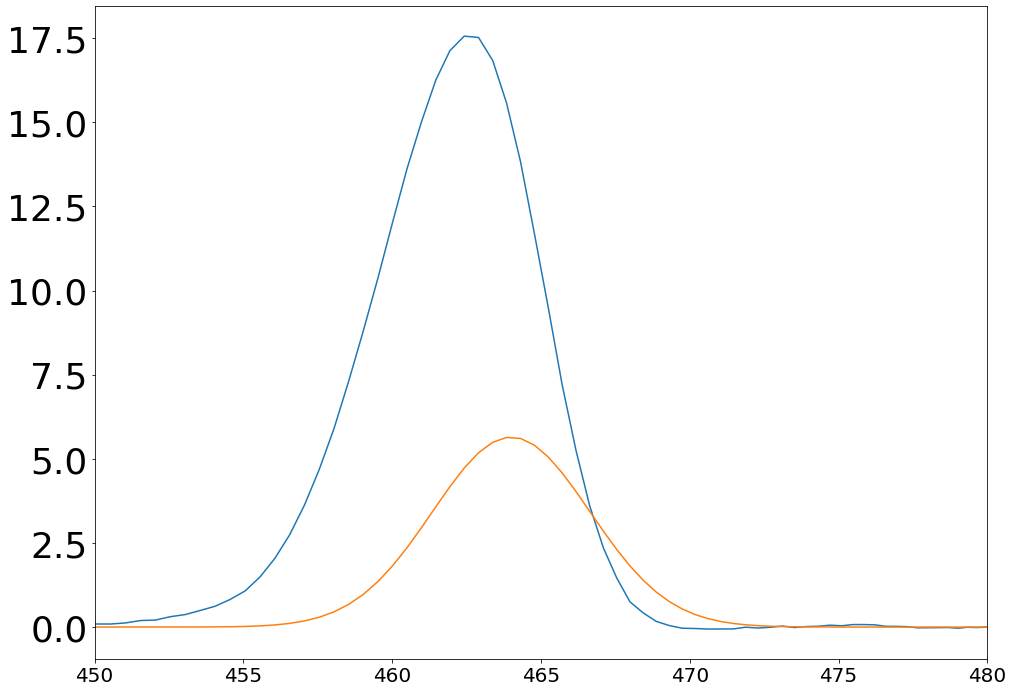


100%|██████████| 1/1 [00:05<00:00,  5.10s/it]

23526520248.16273 531193396.4838562 464.0 5.3


In [187]:
avg_rng=1
up_or_low="up"
data_x,data_y = extract_waist_data(df_1,up_or_low=up_or_low,axis="Y",detector="SPIN",avg_rng=avg_rng,sub_sample=True,plot=True,logscale=False,save=False)
#y_width_spin_2,y_width_spin_err_2,y_mean_spin_2,y_chi2_spin_2,y_fits_spin_2 = extract_waist_data(df_2,up_or_low=up_or_low,axis="Y",detector="SPIN",avg_rng=avg_rng,sub_sample=False,plot=False,logscale=False,save=False)
#y_width_spin,y_width_spin_err,y_mean_spin,y_chi2_spin,y_fits_spin =extract_waist_data(df_y,up_or_low="up",axis="X",detector="SPIN",avg_rng=1,sub_sample=False,plot=False,logscale=False,save=False)

In [167]:
from scipy import stats


  0%|          | 0/1 [00:00<?, ?it/s]

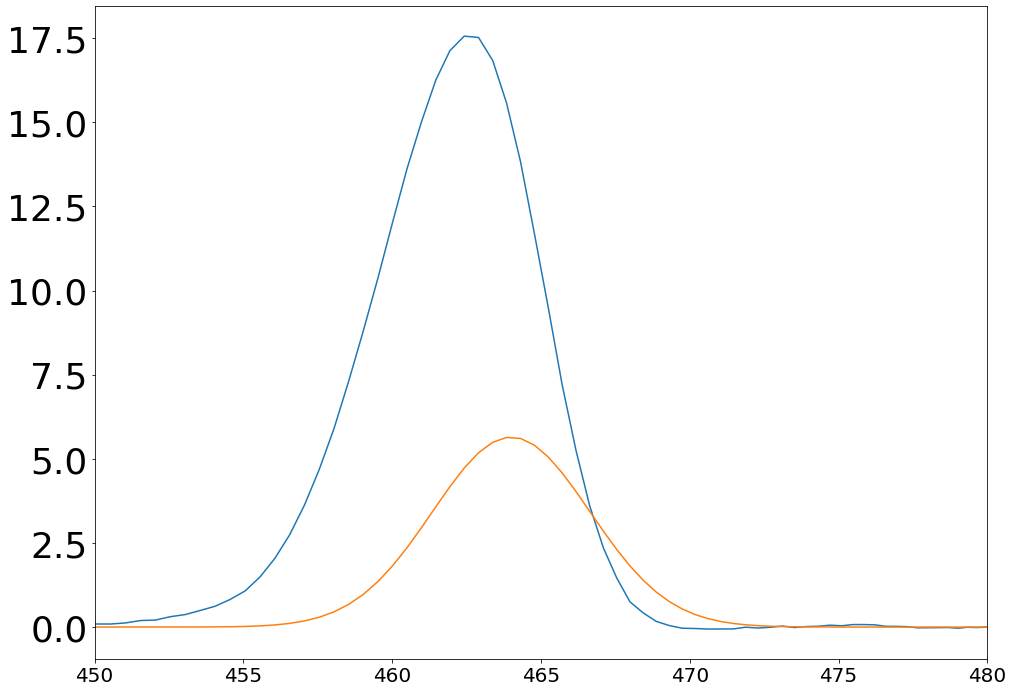


100%|██████████| 1/1 [00:04<00:00,  4.82s/it]

23526520248.16273 531193396.4838562 464.0 5.3


ValueError: not enough values to unpack (expected 5, got 2)

In [179]:
avg_rng=1
up_or_low="up"
y_width_spin_1,y_width_spin_err_1,y_mean_spin_1,y_chi2_spin_1,y_fits_spin_1 = extract_waist_data(df_1,up_or_low=up_or_low,axis="Y",detector="SPIN",avg_rng=avg_rng,sub_sample=True,plot=True,logscale=False,save=False)
#y_width_spin_2,y_width_spin_err_2,y_mean_spin_2,y_chi2_spin_2,y_fits_spin_2 = extract_waist_data(df_2,up_or_low=up_or_low,axis="Y",detector="SPIN",avg_rng=avg_rng,sub_sample=False,plot=False,logscale=False,save=False)
#y_width_spin,y_width_spin_err,y_mean_spin,y_chi2_spin,y_fits_spin =extract_waist_data(df_y,up_or_low="up",axis="X",detector="SPIN",avg_rng=1,sub_sample=False,plot=False,logscale=False,save=False)

In [186]:
scipy.stats.skew(data_y)

3.8091849928209385

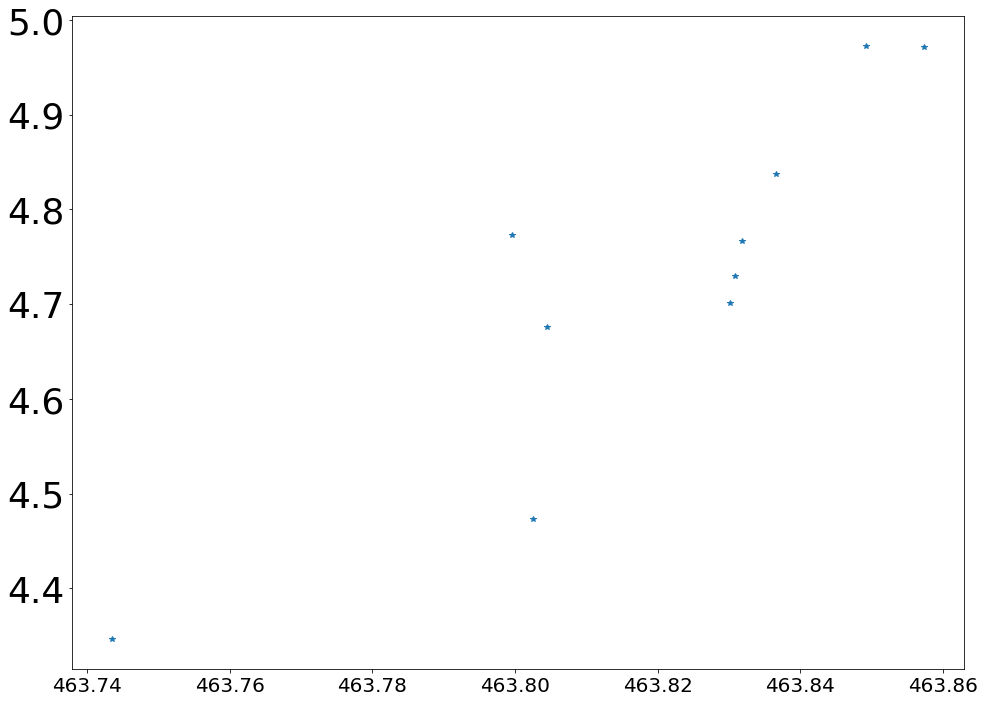

In [67]:
plt.plot(y_mean_spin_1,y_width_spin_1,linestyle="",marker="*")

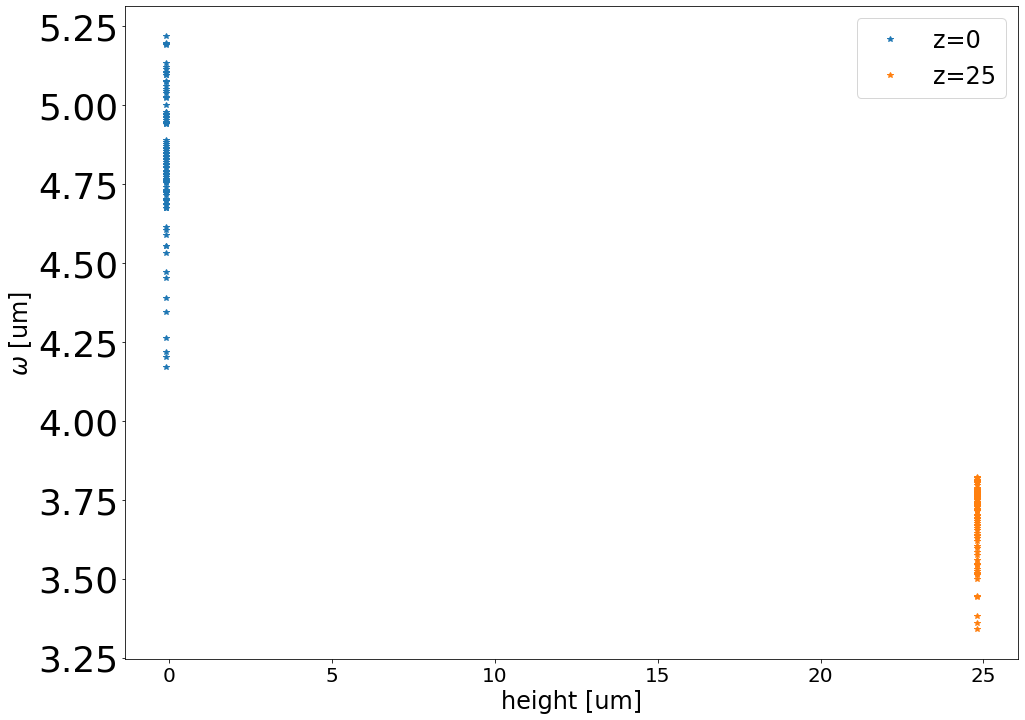

In [22]:
x_for_1 = np.asarray(make_x_axis_for_beam_profile(df_1))
x_for_2 =np.asarray(make_x_axis_for_beam_profile(df_2))
plt.plot(x_for_1, y_width_spin_1,linestyle="",marker="*",label="z=0")
plt.plot(x_for_2, y_width_spin_2,linestyle="",marker="*",label="z=25")
plt.ylabel("$\omega$ [um]")
plt.xlabel("height [um]")
plt.legend()
plt.show()

In [23]:
x_width_spin_1,x_width_spin_err_1,x_mean_spin_1,x_chi2_spin_1,x_fits_spin_1 = extract_waist_data(df_3,up_or_low=up_or_low,axis="X",detector="SPIN",avg_rng=avg_rng,sub_sample=False,plot=False,logscale=False,save=False)


100%|██████████| 100/100 [01:47<00:00,  1.21it/s]

1622947292.3202462 167554298.95953834 237.12442733911686 2.7199050748831124


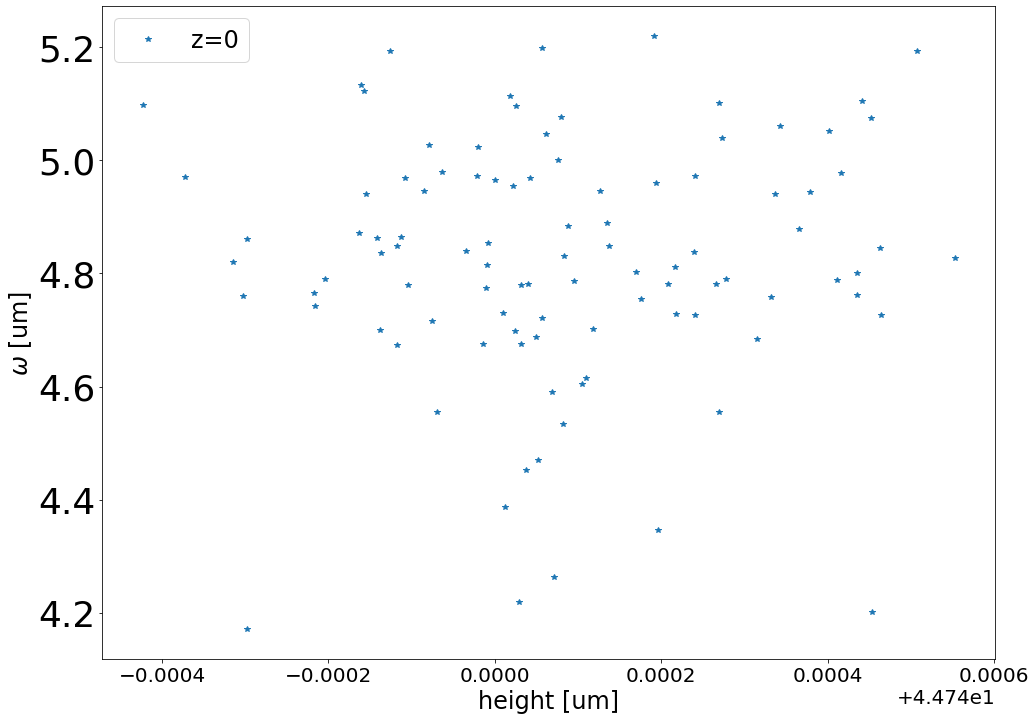

In [24]:
x_for_3 = np.asarray(make_x_axis_for_beam_profile(df_3))
plt.plot(x_for_3, y_width_spin_1,linestyle="",marker="*",label="z=0")
plt.ylabel("$\omega$ [um]")
plt.xlabel("height [um]")
plt.legend()
plt.show()

In [ ]:
return params[0] * np.exp(-2*(np.subtract(x,params[1])**2/(params[2]**2)))+params[3]
